<a href="https://colab.research.google.com/github/zideric/colab/blob/main/Altri_algoritmi_di_ottimizzazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Altri algoritmi di ottimizzazione

utilizziamo la stessa architettura di rete neurale creata in questo  [notebook](https://colab.research.google.com/drive/1XVnUq7_vaP9WQan11Di0JMneXVJyjule#scrollTo=pT-9CQx0BxoJ) al fine di confrontare i diversi algoritmi di ottimizzazione

importiamo i moduli

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

from keras import optimizers

from time import time

def set_seed(seed):
    from os import environ
    environ["PYTHONHASHSEED"] = '0'
    environ["CUDA_VISIBLE_DEVICES"]='-1'
    environ["TF_CUDNN_USE_AUTOTUNE"] ='0'

    from numpy.random import seed as np_seed
    np_seed(seed)
    import random
    random.seed(seed)
    #from tensorflow import set_random_seed
    #set_random_seed(seed) 
    tensorflow.random.set_seed(seed) #per poter riprodurrer i risultati

## Preparazione dei dati

Carichiamo il dataset Fashion MNIST con Keras e processiamo i dati

In [2]:
from keras.datasets import fashion_mnist

labels = ["T-shirt/top","Pantalone","Pullover","Vestito","Cappotto","Sandalo","Maglietta","Sneaker","Borsa","Stivaletto"]

(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

#Encoding delle immagini

X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)

#Normalizziamo, usiamo semplicemente divisione per 255
X_train = X_train/255
X_test = X_test/255

# Encoding del target

num_classes = 10

y_train_dummy = to_categorical(y_train, num_classes)
y_test_dummy = to_categorical(y_test, num_classes)


4423680/4422102 [==============================] - 0s 0us/step


Adesso ogni immagine è codificata in un vettore contenente il valore dei pixel normalizzati disposti su di un'unica riga.
Il target è codificato all'interno di 10 variabili dummy, una per ogni classe, in cui la variabile alla posizione della classe di appartenenza vale 1 (True), mentre le altre valgono 0 (False).

## Funzioni utili

Creiamo delle funzioni visto che dovremo ridefinire e riaddestrare la stessa rete diverse volte cambiando solo la funzione di ottimizzazione

Questa funzione definisce l'architettura del modello impostando un seed comune per l'inizializzazione casuale dei pesi e ritorna il modello

In [3]:
def build_model():
  set_seed(0)

  model = Sequential()
  model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

Questa funzione disegna il grafico della funzione di costo ad ogni epoca

In [4]:
def plot_loss(optimizer, loss):
  plt.figure(figsize=(14,10))
  plt.title(optimizer)
  plt.xlabel("Epoca")
  plt.ylabel("Log-Loss")
  plt.plot(loss)

Questa funzione avvia l'addestramento della rete e cronometra l'esecuzione, infine mostra le metriche accuracy e loss e il grafico con la funzione creata allo step precedente

In [5]:
def train_and_time(model, optimizer,batch_size=512): #imposto default a 512 per congruenza con l'esercizio ma prevedo il parametro per fare diverse prove

  history = History()

  start_at = time()
  model.fit(X_train, y_train_dummy, epochs=100, batch_size=batch_size,callbacks=[history], verbose=0)
  train_time = time() - start_at

  metrics = model.evaluate(X_train, y_train_dummy, verbose=0) #usiamo evaluate cosi salviamo accuracy e loss 

  print("Tempo di addestramento: %d minuti e %d secondi" % (train_time/60,train_time%60))
  print("Accuracy = %.4f - Loss = %.4f" % (metrics[1],metrics[0]))

  plot_loss(optimizer, history.history['loss'])

  return model


## Utilizzare il Momentum

Il momemtum è un concetto proveniente dalla fisica e permette di far convergere il Gradient Descent più velocemente nella direzione corretta, accumulando gli update degli step precendenti.

$$
\begin{align*}
                V_t = \gamma V_{t-1} + \eta \nabla J(W) \\
     W = W - V_t
\end{align*}
$$

Cominciamo costruendo il modello utilizzando la funzione build_model che abbiamo definito prima.

In [10]:
model = build_model()

per impostare il momentum dobbiamo creare un nuovo ottimizzatore di tipo Stochastic Gradient Descent e passare al suo interno nel parametro momentum il valore della costante gamma, che va da 0 a 1, con un valore consigliato di 0.9

In [11]:
sgd = optimizers.SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Avviamo la fase di addestramento utilizzando la funzione train_and_time definita prima.

Tempo di addestramento: 5 minuti e 20 secondi
Accuracy = 0.9755 - Loss = 0.0683


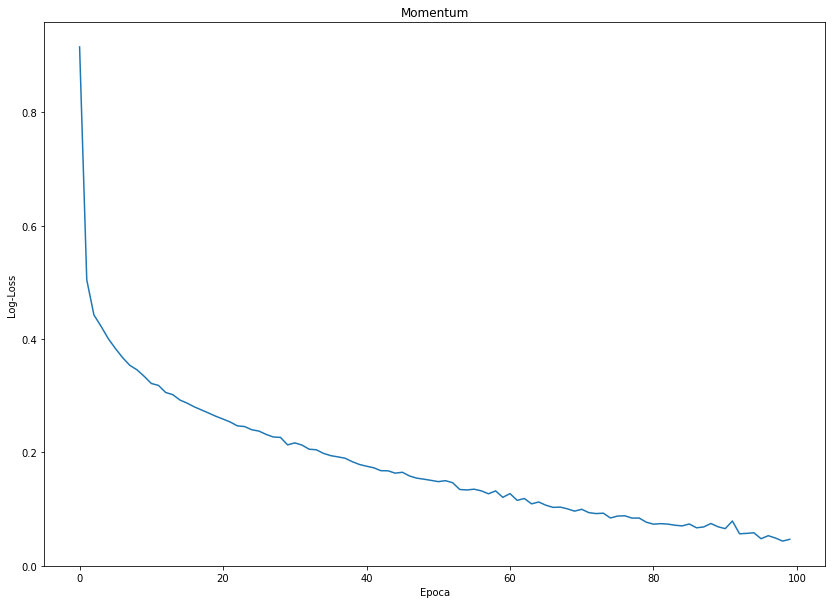

In [12]:
model = train_and_time(model, "Momentum")

## Nesterov Momentum

Il Nesterov Momentum è un espansione del momentum che tenta di prevedere il prossimo step del gradient descent eseguendo una stima con l'update dell'epoca precedente.

$$
\begin{align*}
V_t = \gamma V_{t-1} + \eta \nabla J(W-\gamma V_{t-1}) \\
W = W - V_t
\end{align*}
$$
Per utilizzare il Nesterov Momentum dobbiamo solamente passare il paramentro nesterov=True quando definiamo l'ottimizzatore.

Tempo di addestramento: 5 minuti e 23 secondi
Accuracy = 0.9774 - Loss = 0.0643


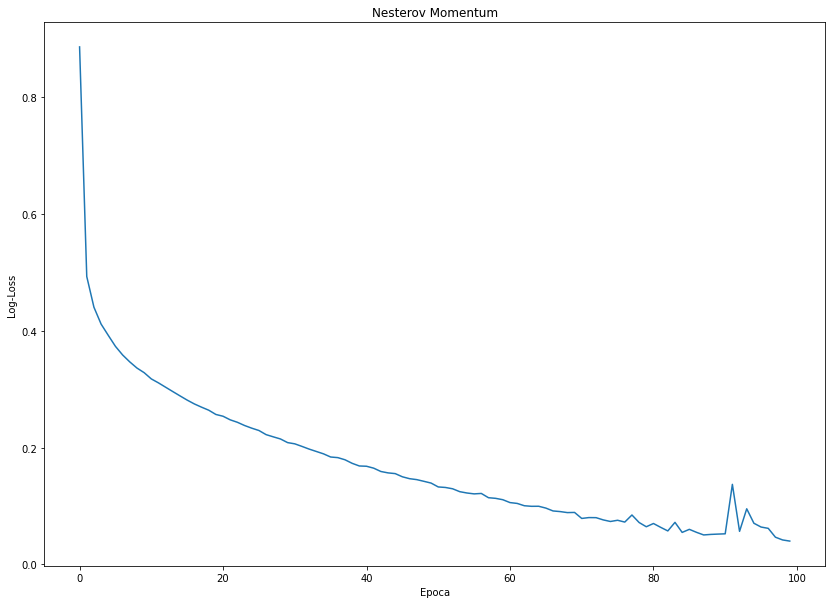

In [14]:
model = build_model() #ricreiamo il modello

sgd = optimizers.SGD(momentum=0.9, nesterov=True) #impostiamo il Nesterov
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model = train_and_time(model, "Nesterov Momentum")


## AdaGrad

L'AdaGrad è un algoritmo di ottimizzazione che permette di ottenere un valore del learning rate dinamico, ciò che varia ad ogni iterazione e che si adatta alle features assumendo valore maggiore per le features più rare.

$$
\begin{align*}
g_t = \nabla J(\theta) \\
\theta = \theta - \frac{\eta}{\sqrt{G_t + \epsilon}}\cdot g_t
\end{align*}
$$
Dove $G_t$ è una matrice diagonale che contiene la somma dei quadrati di ogni derivata parizale delle epoche precedenti, mentre $\epsilon$ è una costante molto piccola ($\approx 1^{-8}$) utilizzata per evitare la divisione per zero.
L'AdaGrad elimina anche il problema di dover selezionare il learning rate manualmente, **infatti un valore standard di 0.01 va bene nella maggior parte dei casi.**

Tempo di addestramento: 5 minuti e 24 secondi
Accuracy = 0.8600 - Loss = 0.4053


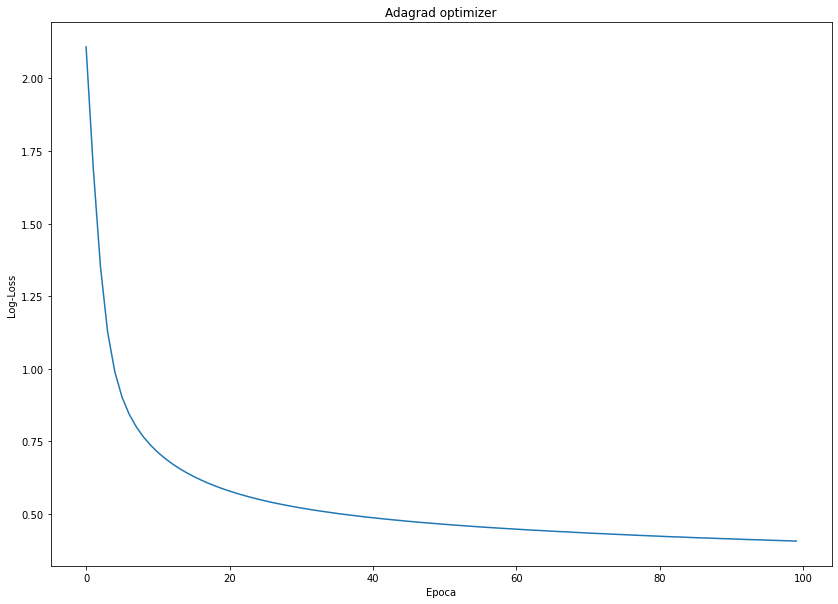

In [15]:
model = build_model()

adagrad = optimizers.Adagrad()
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])

model = train_and_time(model,'Adagrad optimizer')

Lo svantaggio principale dell'AdaGrad è che è troppo aggressivo, andando a ridurre eccessivamente il learning rate con l'avanzare delle epoche.


## RMSprop

L'algoritmo di ottimizzazione RMSprop è una soluzione al problema dell'Adagrad proposta da Geoff Hinton, che piuttosto che accumulare i gradienti di tutte le epoche precedenti, raccoglie solo quelli di un ultimo quadro temporale utilizzando una media mobile esponenziale.

$$
\begin{align*}
g_t = \nabla J(W) \\
E[g^2] = \gamma E[g^2]_{t-1} + (1-\gamma)g^2_t \\
W = W - \frac{\eta}{\sqrt{E[g^2] + \epsilon}}\cdot g_t
\end{align*}
$$
Anche qui il valore consigliato per $\gamma$ è 0.9, mentre per il learning rate è 0.001.

Tempo di addestramento: 5 minuti e 48 secondi
Accuracy = 0.9831 - Loss = 0.0650


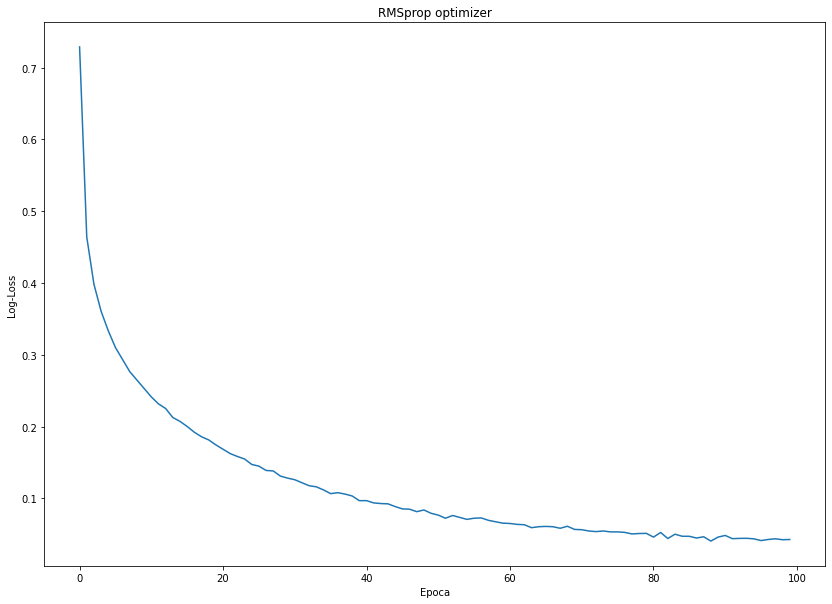

In [16]:
model = build_model()

rmsprop = optimizers.RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

model = train_and_time(model, "RMSprop optimizer")

## Adadelta

L'Adadelta è un'espansione dell'Adagrad che utilizza un approccio del tutto simile al RMSprop per affrontare il problema della riduzione del learning rate.

Per approfondire la parte matematica dell'Adadelta, dai uno sguardo al paper originale su Arxiv: Adadelta: an Adapive Learning Rate Method

Tempo di addestramento: 5 minuti e 28 secondi
Accuracy = 0.8101 - Loss = 0.5899


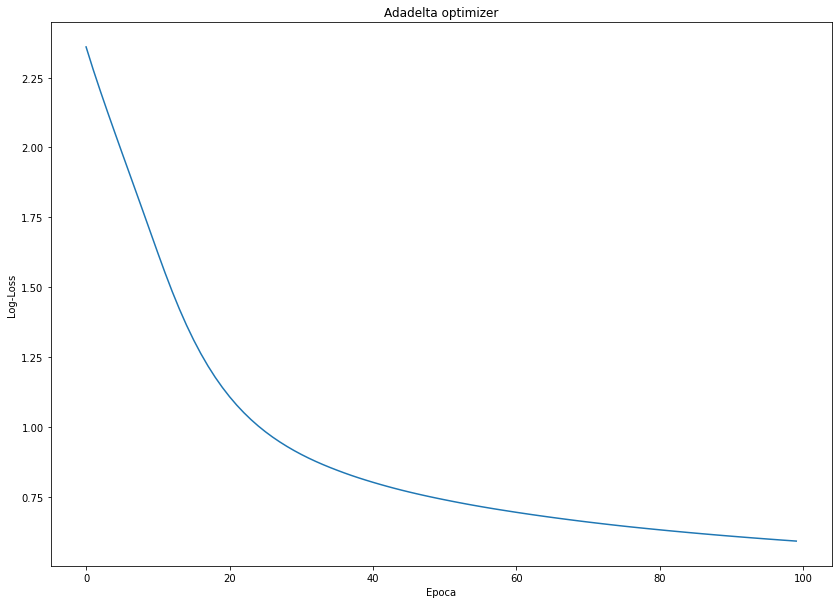

In [17]:
model = build_model()

adadelta = optimizers.Adadelta()
model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

model = train_and_time(model, "Adadelta optimizer")

## Adam

L'Adam è un algoritmo di ottimizzazione basato sul RMSprop che fa anche uso del Momentum

$$
\begin{align*}
g_t = \nabla J(W) \\
m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t \\
v_t = \beta_2 v_{t-1} + (1-\beta_2)g^2_t \\
\hat{m}_t = \frac{m_t}{1-\beta^t_1} \\
\hat{v}_t = \frac{v_t}{1-\beta^t_2} \\
W = W - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}}\cdot \hat{m}_t
\end{align*}
$$
Il valore consigliato per $\beta_1$ è 0.9 e per $\beta_2$ 0.999. Nella pratica è stato dimostrato che Adam è l'algoritmo di ottimizzazione più performante nella maggior parte dei casi, per approfondire dai uno sguardo al paper originale su Arxiv Adam: A Method for Stochastic [Optimization.](https://arxiv.org/abs/1412.6980)



Tempo di addestramento: 5 minuti e 30 secondi
Accuracy = 0.9948 - Loss = 0.0155


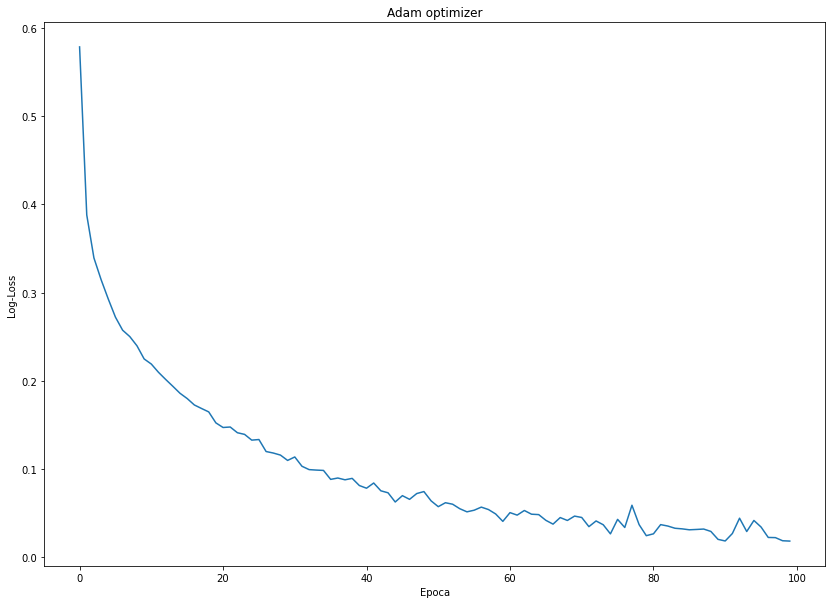

In [18]:
model = build_model()

adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

model = train_and_time(model, "Adam optimizer")

## Adamax

L'algortimo di ottimizzazione Adamax è un'espansione dell'Adam che lo rende più robusto nel caso di array sparsi.

$$
\begin{align*}
\hat{u}_t = \max{(\beta_2 v_{t-1},|g_t|)} \\
\theta = \theta - \frac{\eta}{\hat{u}_t}\cdot \hat{m}_t
\end{align*}
$$
Per approfondire fai sempre riferimento al paper [Adam: A Method for Stochastic Optimization.](https://arxiv.org/abs/1412.6980)

Tempo di addestramento: 5 minuti e 25 secondi
Accuracy = 0.9961 - Loss = 0.0124


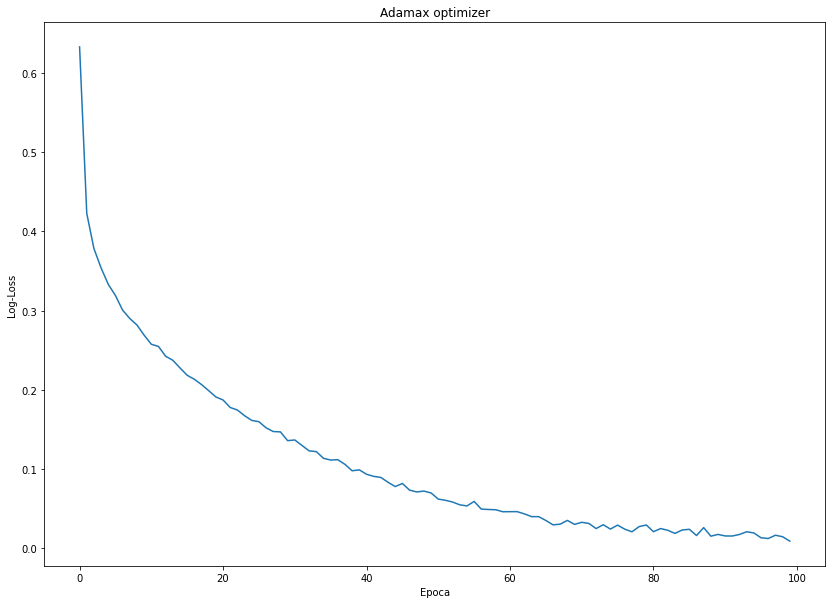

In [20]:
model = build_model()

adamax = optimizers.Adamax()
model.compile(loss='categorical_crossentropy',optimizer=adamax, metrics=['accuracy'])

model = train_and_time(model, "Adamax optimizer")

## Nadam

L'algoritmo di ottimizzazione Nadam è un espansione dell'Adam che fa utilizzo del Nesterov Momentum.$$
\begin{align*}
&amp;\theta = \theta - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}}\cdot (\beta_1 \hat{m}_t + \frac{(1-\beta_1)g_t}{1-\beta_1^t})
\end{align*}
$$

Per approfondire la parte matematica dai uno sguardo a questo paper: [Incorporating Nesterov Momentum into Adam](http://cs229.stanford.edu/proj2015/054_report.pdf)

Tempo di addestramento: 6 minuti e 13 secondi
Accuracy = 0.9968 - Loss = 0.0105


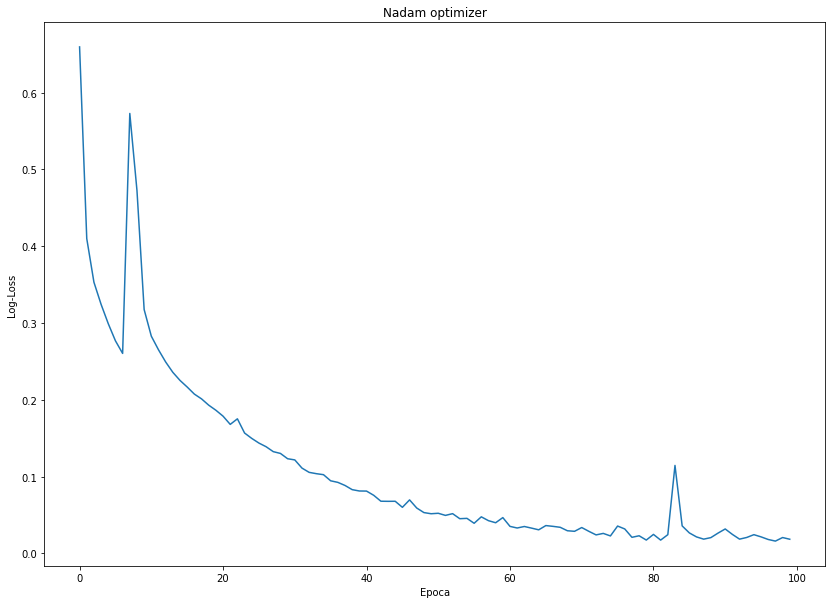

In [22]:
model = build_model()

nadam = optimizers.Nadam()
model.compile(loss='categorical_crossentropy',optimizer=nadam, metrics=['accuracy'])

model = train_and_time(model, "Nadam optimizer")

## Abbiamo creato una super rete neurale?

Sul repositori del [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) possiamo vedere dei benchmark di modelli creati dai ricercatori 
A quanto pare l'accuracy del nostro banalissimo modello, ottenuta con diversi algoritmi di ottimizzazione, è superiore a quella di modelli creati da ricercatori esperti con modelli ben più complessi. E' davvero così ! NO. Il modello va valutato su osservazioni a lui sconosciute, cioè osservazioni che non gli sono state mostrate durante la fase di addestramento. Facciamolo, utilizzando il test set per valutare l'ultimo modello addestrato.



In [23]:
test_metrics = model.evaluate(X_test, y_test_dummy)
print("Log loss su test set: %.4f - Accuracy sul test set: %.4f" % (test_metrics[0], test_metrics[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.9113 - accuracy: 0.8944
Log loss su test set: 0.9113 - Accuracy sul test set: 0.8944
